In [1]:
import math
import torch
import numpy as np

from guided_diffusion.script_util import create_model,create_DIT_model
import mrfft

import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm

def update_pbar_desc(pbar, metrics, labels):
    pbar_string = ''
    for metric, label in zip(metrics, labels):
        pbar_string += f'{label}: {metric:.7f}; '
    pbar.set_description(pbar_string)

%matplotlib inline

In [3]:
model = create_model(
    image_size=256,
    num_channels=128,
    num_res_blocks=2,
    channel_mult="",
    learn_sigma=True,
    class_cond=False,
    use_checkpoint=False,
    attention_resolutions="16,8",
    num_heads=4,
    num_head_channels=-1,
    num_heads_upsample=-1,
    use_scale_shift_norm=True,
    dropout=0,
    resblock_updown=False,
    use_fp16=False,
    use_new_attention_order=False,
)
# model = create_DIT_model(
#     image_size=256,
#     num_channels=128,
#     num_res_blocks=2,
#     channel_mult="",
#     learn_sigma=True,
#     class_cond=False,
#     use_checkpoint=False,
#     attention_resolutions="16,8",
#     num_heads=4,
#     num_head_channels=-1,
#     num_heads_upsample=-1,
#     use_scale_shift_norm=True,
#     dropout=0,
#     resblock_updown=False,
#     use_fp16=False,
#     use_new_attention_order=False,
# )
device = torch.device("cuda:0")
model = model.to(device)
print(model.load_state_dict(torch.load('/home/jupyter-huangshoujin/MRIGDP_paper/fastmri_ema_0.9999_200000.pt', map_location='cpu')))
# print(model.load_state_dict(torch.load('../nila_training/log_DIT/model020000.pt', map_location='cpu')))
model.eval()

betas = np.linspace(0.0001, 0.02, 1000, dtype=np.float64)
betas = torch.from_numpy(betas).float().to(device)

<All keys matched successfully>


In [4]:
def float2cplx(float_in):
    return np.array(float_in[...,0]+1.0j*float_in[...,1], dtype='complex64')

def cplx2float(cplx_in):
    return np.array(np.stack((cplx_in.real, cplx_in.imag), axis=-1), dtype='float32')


import torch.fft as torch_fft
def _ifft(x):
    x = torch_fft.ifftshift(x, dim=(-2, -1))
    x = torch_fft.ifft2(x, dim=(-2, -1), norm='ortho')
    x = torch_fft.fftshift(x, dim=(-2, -1))
    return x

# Centered, orthogonal fft in torch >= 1.7
def _fft(x):
    x = torch_fft.fftshift(x, dim=(-2, -1))
    x = torch_fft.fft2(x, dim=(-2, -1), norm='ortho')
    x = torch_fft.ifftshift(x, dim=(-2, -1))
    return x

In [5]:
def compute_alpha(beta, t):
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
    return a


# form RePaint
def get_schedule_jump(T_sampling, travel_length, travel_repeat):

    jumps = {}
    for j in range(0, T_sampling - travel_length, travel_length):
        jumps[j] = travel_repeat - 1

    t = T_sampling
    ts = []

    while t >= 1:
        t = t-1
        ts.append(t)

        if jumps.get(t, 0) > 0:
            jumps[t] = jumps[t] - 1
            for _ in range(travel_length):
                t = t + 1
                ts.append(t)

    ts.append(-1)

    _check_times(ts, -1, T_sampling)

    return ts

def _check_times(times, t_0, T_sampling):
    # Check end
    assert times[0] > times[1], (times[0], times[1])

    # Check beginning
    assert times[-1] == -1, times[-1]

    # Steplength = 1
    for t_last, t_cur in zip(times[:-1], times[1:]):
        assert abs(t_last - t_cur) == 1, (t_last, t_cur)

    # Value range
    for t in times:
        assert t >= t_0, (t, t_0)
        assert t <= T_sampling, (t, T_sampling)

In [6]:
def inverse_data_transform(x):
    x = (x + 1.0) / 2.0
    return x

def data_transform(x):
    x = (2 * x) - 1.0
    return x

In [7]:
import h5py

slice = 7
data = np.load('/home/jupyter-huangshoujin/MRIGDP_paper/M4Raw_test/real_01/2022101201_T201.npy',allow_pickle=True).item()
kspace = data['kspace'][slice]
coilsen = data['csm'][slice]
g_mask = data['mask'][slice]

NEX_1 = data['rss'][slice]
NEX_N = data['repeatN'][slice]

nx, ny = kspace.shape[:2]
img_shape = [nx, ny]

from fastmri.data.subsample import create_mask_for_mask_type
import torch
mask_func = create_mask_for_mask_type(
        'equispaced_fraction', [0.04], [3]
    )
mask, num_low_frequencies = mask_func(shape=(1,nx,ny,1),offset=0,seed=1234)
mask = torch.ones([1,nx,ny,1]) * mask
mask = mask[0,...,0].numpy()
print('num_low_frequencies:',num_low_frequencies)

noisy_rss = np.sum(np.multiply(mrfft.ifft2c(kspace,axes=(0,1)), np.squeeze(np.conj(coilsen))), axis=2)

und_ksp = kspace*abs(mask[..., np.newaxis])

und_ksp = torch.from_numpy(und_ksp).permute(2,0,1)[None].to(device)
mask = torch.from_numpy(mask)[None][None].to(device)
coilsen = torch.from_numpy(coilsen).permute(2,0,1)[None].to(device)
zero_filled = torch.sum((_ifft(und_ksp) * torch.conj(coilsen)),dim=1)

num_low_frequencies: 10


In [8]:
zero_filled.shape

torch.Size([1, 256, 256])

In [9]:
def ddnm_diffusion(xt, model, b, T, sigma_y, step_size, arg_iters,  cond_func=None):
    skip = 1000 / T
    n = x.size(0)
    losses = []

    times = get_schedule_jump(T, 1, 1)
    time_pairs = list(zip(times[:-1], times[1:]))        

    pbar = tqdm(time_pairs)
    pbar_labels = ['loss', 'mean', 'min', 'max']

    k_init = 0
    b_init = 0
    
    # Reverse diffusion + Nila-DC
    for i, j in pbar:
        i, j = i*skip, j*skip
        if j<0: j=-1 

        t       = (torch.ones(n) * i).to(x.device)
        next_t  = (torch.ones(n) * j).to(x.device)
        at      = compute_alpha(b, t.long())
        at_next = compute_alpha(b, next_t.long())
        sigma_t = (1 - at_next).sqrt()[0, 0, 0, 0]
        a       = at_next.sqrt()[0, 0, 0, 0]
        
        et = model(xt, t)[:, :2]

        xt = (1/at.sqrt()) * (xt - et * (1 - at).sqrt()) # Eq.6
        
        for _ in range(arg_iters): # Fig.2 (a) (for best DC)
            meas_grad = cond_func(xt) 

            if sigma_t / a >  sigma_y: # Eq.10 (lambda function)
                factor = 1
            else:
                if k_init == 0 and b_init==0:
                    k_init = 0.2 / (-1 * i)
                    b_init = -999 * k_init
                factor = k_init * (999 - i) + b_init
            
            xt = xt - factor * meas_grad * step_size
        xt_1 = at_next.sqrt() * xt + torch.randn_like(xt) * sigma_t # Eq.11

        metrics = [(meas_grad).norm(), (xt).abs().mean(), (xt).abs().min(), (xt).abs().max()]
        update_pbar_desc(pbar, metrics, pbar_labels)
        xt = xt_1
    return xt

In [10]:
def cond_func(x, measurement, mask, coilsen):

    x = inverse_data_transform(x)
    x = torch.view_as_complex(x.permute(0,2,3,1).contiguous())[:,None]
    
    k_x = _fft(x * coilsen)
    x   = _ifft(k_x * mask)
    x = torch.sum(x * torch.conj(coilsen), axis=1)

    grad = x - measurement
    grad = torch.view_as_real(grad).permute(0,3,1,2)
    return grad

grad_params = {'measurement': zero_filled, 'mask': mask, 'coilsen': coilsen}
AHA         = partial(cond_func, **grad_params)

N = 1 # High N to get high best visuliazation.
shape = [2,nx,ny]

with torch.no_grad():
    x = torch.randn([N] + shape).to(device)
    x = ddnm_diffusion(x, model, betas, T=1000, sigma_y=0.1, step_size=2, arg_iters=4, cond_func=AHA)

loss: 9.0758228; mean: 1.0037117; min: 0.0000459; max: 3.3950396; : 100%|██████████| 1000/1000 [00:55<00:00, 18.14it/s]


In [11]:
images        = float2cplx(inverse_data_transform(torch.mean(x,dim=(0))).cpu().permute(1,2,0))

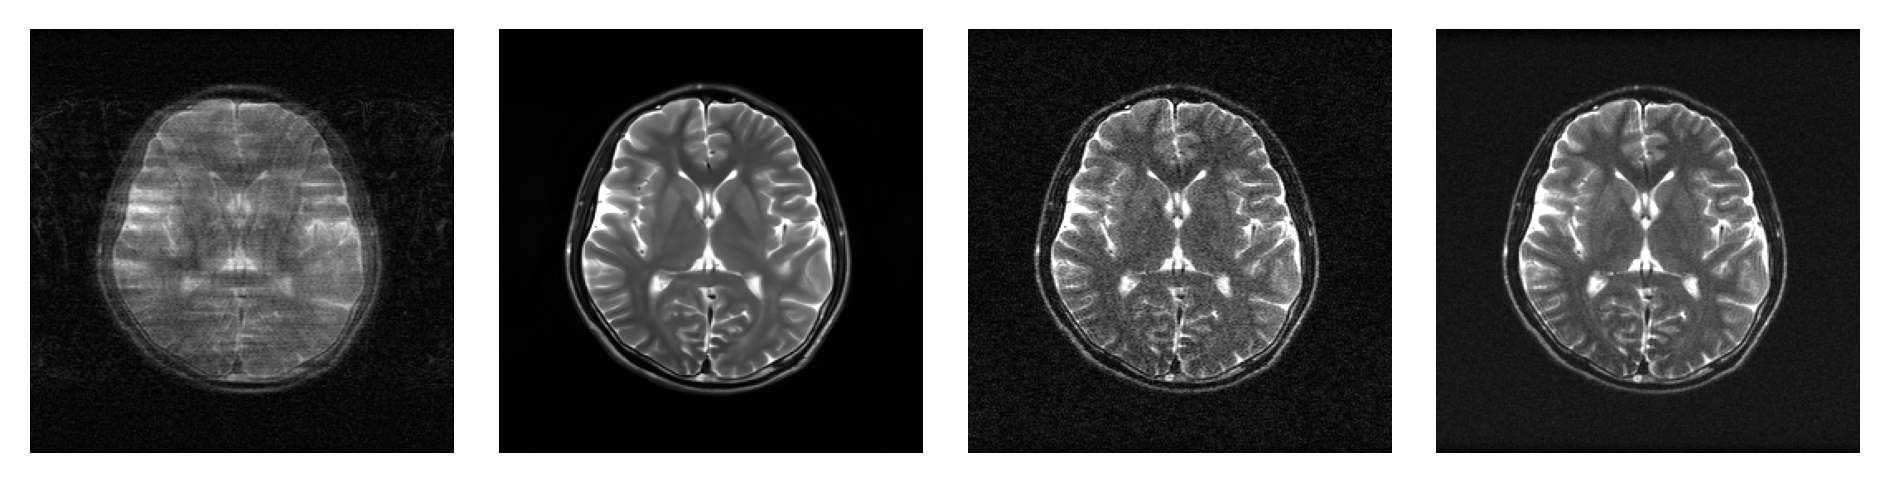

In [14]:
plt.figure(dpi=300)

plt.subplot(1,4,1)
plt.imshow(np.abs(zero_filled[0].cpu().numpy()),cmap='gray',vmax=0.9)
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(np.abs(images),cmap='gray',vmax=0.9)
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(np.abs(NEX_1),cmap='gray',vmax=0.9)
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(np.abs(NEX_N),cmap='gray',vmax=0.9)
plt.axis('off')

plt.tight_layout()
plt.show()